# Benchmark CEM vs DecentCEM on the Rosenbrock Function

This notebook compares the vanilla CEM optimizer with the decentralized variant on the 2D Rosenbrock function. Both optimizers use the same total number of samples per iteration.

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import mbrl.planning as planning

torch.manual_seed(0)
np.random.seed(0)

In [11]:
def rosenbrock_fn(x: torch.Tensor) -> torch.Tensor:
    x1, x2 = x[:, 0], x[:, 1]
    return -((1 - x1) ** 2 + 100 * (x2 - x1 ** 2) ** 2)

lb = [-2.0, -2.0]
ub = [2.0, 2.0]
n = 200
x1 = np.linspace(lb[0], ub[0], n)
x2 = np.linspace(lb[1], ub[1], n)
x1s, x2s = np.meshgrid(x1, x2)
x = np.stack([x1s.flatten(), x2s.flatten()]).T
z = rosenbrock_fn(torch.from_numpy(x).float()).numpy().reshape((n, n))

In [12]:
def run_optimizer(optimizer, x0, iters):
    history = {"best": [], "mean": [], "samples": []}

    def callback(population, values, it):
        flat_pop = population.reshape(-1, 2)
        history["best"].append(float(values.max()))
        history["mean"].append(float(values.mean()))
        if it in (0, iters - 1):
            idx = torch.randperm(flat_pop.shape[0])[:200]
            history["samples"].append(flat_pop[idx].cpu().numpy())

    best = optimizer.optimize(rosenbrock_fn, x0, callback=callback)
    history["best_point"] = best.cpu().numpy()
    history["best_value"] = float(rosenbrock_fn(best.unsqueeze(0)))
    return history

In [15]:
device = torch.device("cpu")
iters = 3 
total_population = 1000
elite_ratio = 0.1
alpha = 0.2
num_workers = 5
per_worker_population = total_population // num_workers

cem = planning.CEMOptimizer(
    num_iterations=iters,
    elite_ratio=elite_ratio,
    population_size=total_population,
    lower_bound=lb,
    upper_bound=ub,
    alpha=alpha,
    device=device,
    return_mean_elites=True,
    clipped_normal=False,
)

decent_cem = planning.DecentCEMOptimizer(
    num_iterations=iters,
    elite_ratio=elite_ratio,
    population_size=per_worker_population,
    lower_bound=lb,
    upper_bound=ub,
    alpha=alpha,
    device=device,
    num_workers=num_workers,
    return_mean_elites=True,
    clipped_normal=False,
)

gmm_cem = planning.GMMCEMOptimizer(
    num_iterations=iters,
    elite_ratio=elite_ratio,
    population_size=per_worker_population,
    lower_bound=lb,
    upper_bound=ub,
    alpha=alpha,
    device=device,
    num_workers=num_workers,
    return_mean_elites=True,
    clipped_normal=False,
)

cma_es = planning.CMAESOptimizer(
    num_iterations=iters,
    population_size=total_population,
    elite_ratio=elite_ratio,
    sigma=1.0,
    lower_bound=lb,
    upper_bound=ub,
    alpha=alpha,
    device=device,
    adaptation="full",
    return_mean_elites=False,
)

x0 = torch.zeros(2, device=device)
cem_hist = run_optimizer(cem, x0, iters)
decent_hist = run_optimizer(decent_cem, x0, iters)
gmm_hist = run_optimizer(gmm_cem, x0, iters)
cma_hist = run_optimizer(cma_es, x0, iters)


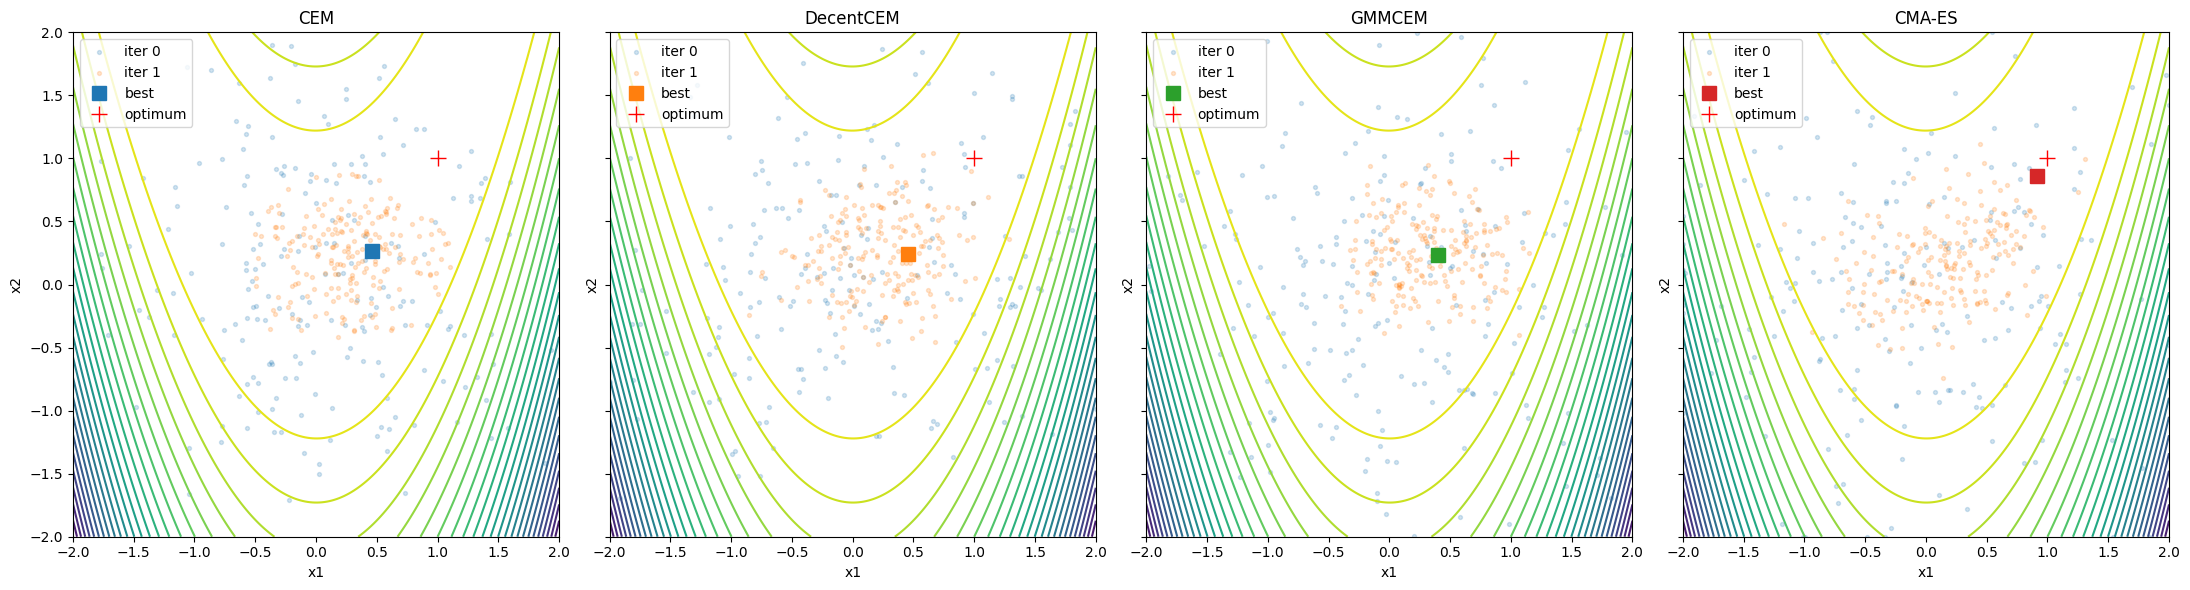

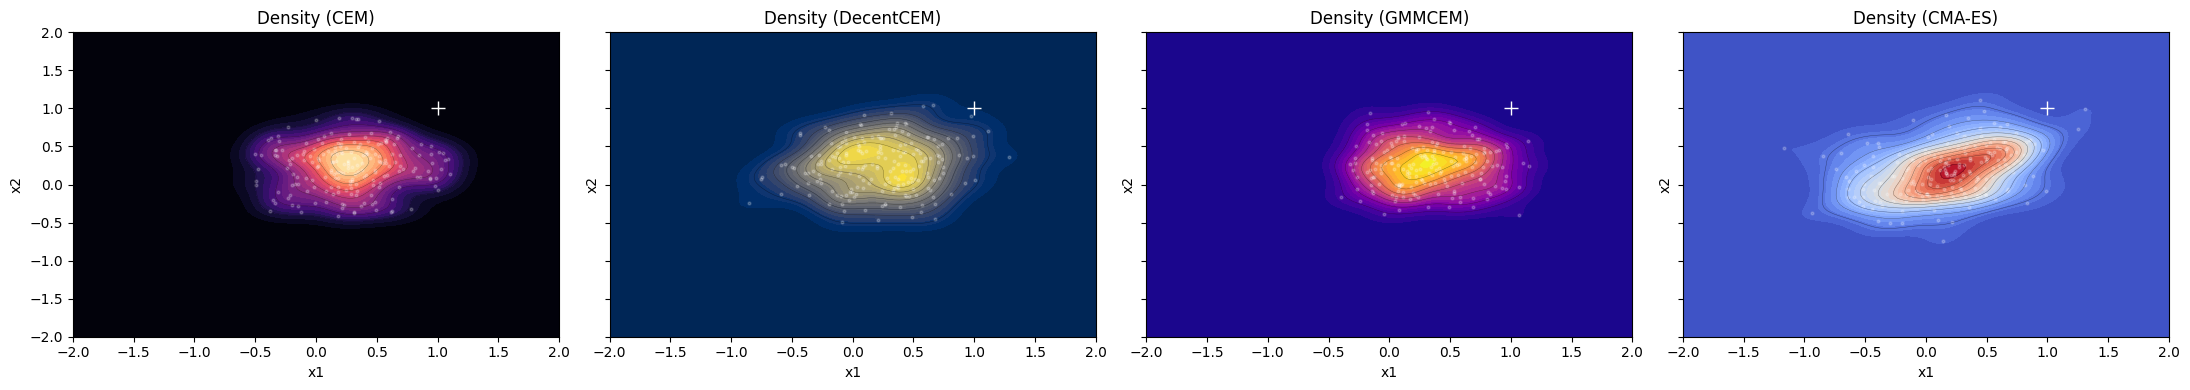

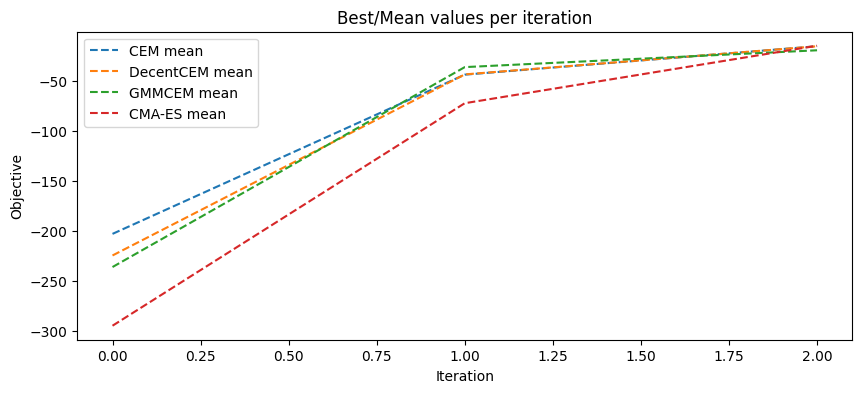

CEM best value: -0.6052844524383545 at [0.46058524 0.26820266]
DecentCEM best value: -0.4255451560020447 at [0.45255905 0.24028555]
GMMCEM best value: -0.9232817888259888 at [0.3972426  0.23263252]
CMA-ES best value: -0.06727400422096252 at [0.9162615 0.8640834]


In [17]:
fig, axes = plt.subplots(1, 4, figsize=(22, 6), sharex=True, sharey=True)
for ax, hist, title, color in [
    (axes[0], cem_hist, "CEM", "tab:blue"),
    (axes[1], decent_hist, "DecentCEM", "tab:orange"),
    (axes[2], gmm_hist, "GMMCEM", "tab:green"),
    (axes[3], cma_hist, "CMA-ES", "tab:red"),
]:
    ax.contour(x1s, x2s, z, levels=30, cmap="viridis")
    for idx, samples in enumerate(hist["samples"]):
        ax.scatter(samples[:, 0], samples[:, 1], s=8, alpha=0.2, label=f"iter {idx}")
    bp = hist["best_point"]
    ax.plot(bp[0], bp[1], "s", color=color, markersize=10, label="best")
    ax.plot(1, 1, "r+", markersize=12, label="optimum")
    ax.set_title(title)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.legend(loc="upper left")

plt.tight_layout()
plt.show()

from scipy.stats import gaussian_kde

def plot_kde(ax, samples, title, cmap):
    kde = gaussian_kde(samples.T)
    xx, yy = np.mgrid[lb[0]:ub[0]:100j, lb[1]:ub[1]:100j]
    grid = np.vstack([xx.ravel(), yy.ravel()])
    zz = kde(grid).reshape(xx.shape)
    cf = ax.contourf(xx, yy, zz, levels=25, cmap=cmap)
    ax.contour(xx, yy, zz, levels=10, colors="k", linewidths=0.3, alpha=0.5)
    ax.scatter(samples[:, 0], samples[:, 1], s=4, alpha=0.2, color="white")
    ax.plot(1, 1, "w+", markersize=10, label="optimum")
    ax.set_title(f"Density ({title})")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    return cf

fig, axes = plt.subplots(1, 4, figsize=(22, 4), sharex=True, sharey=True)
cmaps = ["magma", "cividis", "plasma", "coolwarm"]
for ax, hist, title, cmap in [
    (axes[0], cem_hist, "CEM", cmaps[0]),
    (axes[1], decent_hist, "DecentCEM", cmaps[1]),
    (axes[2], gmm_hist, "GMMCEM", cmaps[2]),
    (axes[3], cma_hist, "CMA-ES", cmaps[3]),
]:
    samples = hist["samples"][-1]
    plot_kde(ax, samples, title, cmap)

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 4))
t = np.arange(iters)
# ax.plot(t, cem_hist["best"], label="CEM best")
# ax.plot(t, decent_hist["best"], label="DecentCEM best")
# ax.plot(t, gmm_hist["best"], label="GMMCEM best")
# ax.plot(t, cma_hist["best"], label="CMA-ES best")
ax.plot(t, cem_hist["mean"], "--", label="CEM mean")
ax.plot(t, decent_hist["mean"], "--", label="DecentCEM mean")
ax.plot(t, gmm_hist["mean"], "--", label="GMMCEM mean")
ax.plot(t, cma_hist["mean"], "--", label="CMA-ES mean")
ax.set_xlabel("Iteration")
ax.set_ylabel("Objective")
ax.set_title("Best/Mean values per iteration")
ax.legend()
plt.show()

print("CEM best value:", cem_hist["best_value"], "at", cem_hist["best_point"])
print("DecentCEM best value:", decent_hist["best_value"], "at", decent_hist["best_point"])
print("GMMCEM best value:", gmm_hist["best_value"], "at", gmm_hist["best_point"])
print("CMA-ES best value:", cma_hist["best_value"], "at", cma_hist["best_point"])
